In [49]:
%load_ext autoreload
%autoreload 2

In [50]:
from typing import Any, Callable, Dict, List, Optional, Tuple

import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx
import nolds
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from matplotlib.figure import Figure
from scipy.stats import entropy
from sklearn.impute import KNNImputer  # noqa: F401

from utils import (
    DATADIR,
    FIGDIR,
    MIN_VALUE_THRESHOLD,
    NAN_THRESHOLD,
    AdjacencyMethod,
    DistanceTransformation,
    EventData,
    GraphEvent,
    Normalizer,
    graph_fractal_dimension,
    load_events,
    setup_plotting,
)

setup_plotting()

## Preprocess DataFrames

tandardize all events to 5-min. And, apparently, the data cannot have any NaN value, so I'll try to input data

In [51]:
def invalid_stations(station_df: pd.DataFrame, use_threshold: bool) -> List[str]:
    """Check if a station has less than NAN_THRESHOLD percentage of NaN values."""
    nan_ratios = station_df.isna().mean()

    if use_threshold:
        invalid_stations = nan_ratios[nan_ratios >= NAN_THRESHOLD].index.tolist()
    else:
        invalid_stations = nan_ratios[nan_ratios > 0].index.tolist()

    return invalid_stations

In [52]:
events = load_events()

# Fill data preprocessing
for event_name, data in events.items():
    df = data["raw"]

    # Drop stations with too many NaNs
    stations_to_drop = invalid_stations(df, use_threshold=False)
    df = df.drop(columns=stations_to_drop)

    # Impute missing values using KNN Imputer
    # imputer = KNNImputer(n_neighbors=2, weights="uniform")
    # df.loc[:, :] = imputer.fit_transform(df)

    # Resample to 5-minute intervals using median
    events[event_name]["raw"] = df.resample("5min").median()

    print(f"Event {event_name}: Dropped stations {stations_to_drop}")

Event 2024-05-10: Dropped stations ['IRK2', 'FSMT', 'JBGO']
Event 2024-03-24: Dropped stations ['ATHN', 'JBGO']
Event 2023-04-23: Dropped stations ['CALM', 'JBGO']
Event 2002-04-17: Dropped stations ['DRBS']
Event 2003-10-29: Dropped stations ['DRBS']
Event 2003-11-20: Dropped stations ['ESOI', 'DRBS', 'MOSC', 'THUL']
Event 2004-11-09: Dropped stations ['DRBS']
Event 2005-01-21: Dropped stations ['DRBS', 'SOPB']
Event 2005-05-14: Dropped stations ['MXCO', 'DRBS', 'MOSC']
Event 2005-08-24: Dropped stations ['DRBS', 'PWNK']
Event 2005-09-10: Dropped stations ['ATHN', 'DRBS', 'SOPB', 'SOPO']
Event 2006-12-14: Dropped stations ['DRBS', 'FSMT']
Event 2011-10-24: Dropped stations ['IRKT', 'MGDN', 'FSMT']
Event 2012-03-08: Dropped stations ['NANM']
Event 2012-07-14: Dropped stations ['ESOI', 'NANM', 'IRK3', 'MGDN', 'APTY']
Event 2015-06-22: Dropped stations ['IRK2', 'KERG', 'SOPB', 'SOPO', 'TERA']
Event 2017-09-07: Dropped stations ['MXCO', 'AATB']
Event 2021-11-03: Dropped stations ['DJON', 

## Create Graphs & Compare normalization methods

Based on [001_tests_with_graphs.ipynb](./001_tests_with_graphs.ipynb), the best methods are: `MANHATTAN` & `MINKOWSKI`, so I'll be using only those. The data will be previously normalized with diferents methods in order to compare.

A new kind of graph is calculated, the "count" is not used to construct the adjacency matrix, now the matrix is calculated using the percentual change: $x_{i\%} = \frac{x_{i} - x_{i-1}}{x_{i-1}}$. When $i = 0$, $x_{i\%} = 0$; when $x_{i-1} = 0$, is replaced to `MIN_VALUE_THRESHOLD` (1e-16). This new data it's calculated when there isn't a normalization method.

We calculated percentual change, but it was not a relevant metric, so we deleted it

### Create all the dataset

In [53]:
valid_methods = (AdjacencyMethod.MANHATTAN, AdjacencyMethod.MINKOWSKI)

In [54]:
def calc_graph_metrics(
    events: Dict[str, EventData],
    *,
    transform_method: DistanceTransformation = DistanceTransformation.NONE,
    threshold: float = 0.0,
) -> Tuple[pd.DataFrame, List[Dict[str, Any]]]:
    def calculate_avg_node_metric(
        metrics: Dict[str, float],
        fn: Optional[Callable[[np.ndarray], float]] = None,
        *,
        value_per_node: Optional[Dict[str, float]] = None,
    ) -> float:
        if fn is None:
            fn = lambda nums: float(nums.mean())  # noqa: E731

        if value_per_node is None:
            value_per_node = {}

        values = np.array(
            list(
                map(
                    lambda item: item[1] * value_per_node.get(item[0], 1.0),
                    metrics.items(),
                )
            )
        )
        return fn(values)

    dataset = []

    # 4 nested loops... damn
    for event_date, data in events.items():
        for method in valid_methods:
            for normalization in Normalizer:
                raw_df = data["raw"].reset_index(drop=True)

                # Transform raw_df data before any normalization
                transformed_data = transform_method.transform(raw_df.to_numpy())
                transformed_df = pd.DataFrame(transformed_data, columns=raw_df.columns)

                # Normalize data
                columns = transformed_df.columns
                normalized_data = normalization.normalize(transformed_df.to_numpy())
                normalized_df = pd.DataFrame(normalized_data, columns=columns)
                nan_sum = normalized_df.isna().sum()
                nan_columns = nan_sum[nan_sum > 0].index.tolist()
                if nan_columns:
                    print(f"[WARNING] NAN COLUMNS DROPPED: {nan_columns}")
                    normalized_df.drop(columns=nan_columns, inplace=True)

                # Replace all zeros with a small value to avoid issues in pct_change (infinite values)
                normalized_df[normalized_df.abs() < MIN_VALUE_THRESHOLD] = (
                    MIN_VALUE_THRESHOLD
                )

                # Generate graph
                thresholded_df = normalized_df.copy()
                if threshold > 0.0:
                    thresholded_df[normalized_df.abs() > threshold] = (
                        MIN_VALUE_THRESHOLD
                    )

                graph_event = GraphEvent(
                    data=thresholded_df,
                    metadata={
                        # Event metadata
                        "drop": data.get("drop", 0.0),
                        "intensity": data.get("intensity", "Unknown"),
                        "dst": data.get("dst", 0.0),
                        # Station metadata
                        "cutoff_rigidity": data["cutoff_rigidity"],
                        "altitude": data["altitude"],
                    },
                )

                try:
                    graph = graph_event.get_graph_networkx(method)
                except Exception:
                    print("Processing event:", event_date)
                    print("Using method:", method.value)
                    print("Using normalization:", normalization.value)

                    print("\nraw_df snapshot:")
                    nan_sum = raw_df.isna().sum()
                    display(nan_sum[nan_sum > 0])

                    print("transformed_df snapshot:")
                    nan_sum = transformed_df.isna().sum()
                    display(transformed_df)
                    display(nan_sum[nan_sum > 0])

                    print("normalized_df snapshot:")
                    nan_sum = normalized_df.isna().sum()
                    display(normalized_df)
                    display(nan_sum[nan_sum > 0])

                    print("Final thresholded_df snapshot:")
                    nan_sum = thresholded_df.isna().sum()
                    display(nan_sum[nan_sum > 0])

                    raise

                # Calculate MST and store it
                graph = nx.minimum_spanning_tree(graph)
                events[event_date]["graphs"][method] = graph

                # Weight distribution in order to calculate other metrics
                weights = np.array(
                    list(map(lambda item: item[2]["weight"], graph.edges(data=True)))
                )

                # Global graph metrics
                dataset.append(
                    {
                        "event_date": event_date,
                        # Event metadata
                        "drop": data.get("drop", 0.0),
                        "intensity": data.get("intensity", "Unknown"),
                        "dst": data.get("dst", 0.0),
                        # Metric metadata
                        "normalization": normalization.value,
                        "adjacency_method": method.value,
                        "graph": graph,
                        # Graph global metrics
                        "global_efficiency": nx.global_efficiency(graph),
                        "estrada_index": nx.estrada_index(graph),
                        "entropy": entropy(weights),
                        "fractal": graph_fractal_dimension(graph, seed=37)[0],
                        "hurst_rs": nolds.hurst_rs(weights, fit="poly"),
                        "modularity": nx.algorithms.community.modularity(
                            graph,
                            list(
                                nx.algorithms.community.greedy_modularity_communities(
                                    graph
                                )
                            ),
                        ),
                        "assortativity": nx.degree_assortativity_coefficient(graph),
                        # Average node metrics
                        "avg_katz": calculate_avg_node_metric(
                            nx.katz_centrality(graph)
                        ),
                        "avg_closeness": calculate_avg_node_metric(
                            nx.closeness_centrality(graph)
                        ),
                        "avg_betweenness": calculate_avg_node_metric(
                            nx.betweenness_centrality(graph)
                        ),
                        "avg_laplacian": calculate_avg_node_metric(
                            nx.laplacian_centrality(graph)
                        ),
                    }
                )

    dataset_df = pd.DataFrame(dataset)
    return dataset_df, dataset

In [55]:
transform_method = DistanceTransformation.EXPONENTIAL
dataset_df, dataset = calc_graph_metrics(events, transform_method=transform_method)

METRIC_COLUMNS = [
    "global_efficiency",  # x1
    "entropy",  # x2
    "hurst_rs",  # x3
    "fractal",  # x4
    "modularity",  # x5
    "assortativity",  # x6
    "estrada_index",  # x7
    "avg_katz",  # x8
    "avg_closeness",  # x9
    "avg_betweenness",  # x10
    "avg_laplacian",  # x11
]

In [ ]:
dataset_df.drop(columns=["graph"]).to_csv(DATADIR / "dataset.csv", index=False)

In [56]:
norm_method = Normalizer.MIN_MAX
adjacency_method = AdjacencyMethod.MANHATTAN

df0 = dataset_df[
    (dataset_df["normalization"] == norm_method.value)
    & (dataset_df["adjacency_method"] == adjacency_method.value)
].sort_values(by="intensity")[[*METRIC_COLUMNS, "intensity"]]

x0 = df0.drop(columns=["intensity"]).astype(float).values
y = (
    df0["intensity"]
    .replace(
        ["G1", "G2", "G3", "G4", "G5", "Unknown", np.nan, "G4/G5", "G3/G4"],
        [1, 2, 3, 4, 5, 0, 0, 4.5, 3.5],
    )
    .astype(float)
    .values
)

x0 = sm.add_constant(x0)  # Adds a constant term to the predictor
model = sm.OLS(y, x0).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.359
Model:                            OLS   Adj. R-squared:                  0.065
Method:                 Least Squares   F-statistic:                     1.221
Date:                Sun, 08 Feb 2026   Prob (F-statistic):              0.326
Time:                        19:10:34   Log-Likelihood:                -49.607
No. Observations:                  36   AIC:                             123.2
Df Residuals:                      24   BIC:                             142.2
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -42.6222    102.063     -0.418      0.6

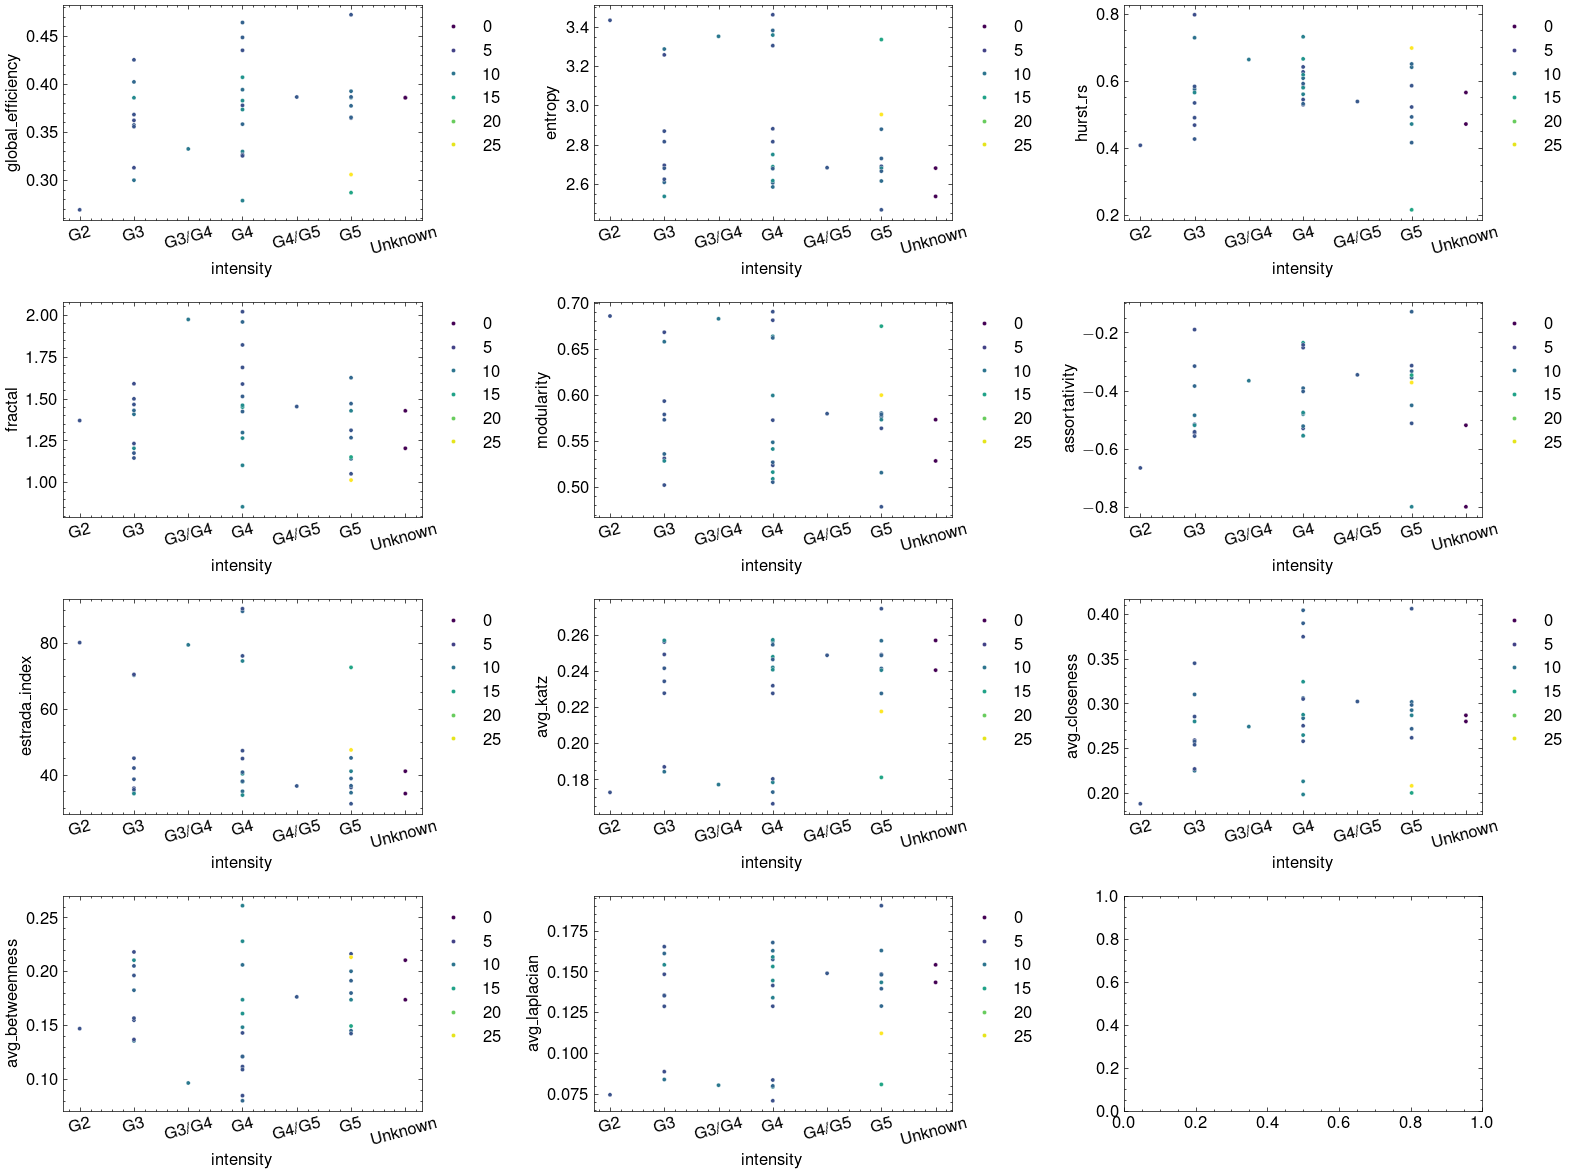

In [59]:
fig, axes = plt.subplots(4, 3, figsize=(16, 12))
axes = axes.flatten()

for metric, ax in zip(METRIC_COLUMNS, axes):
    sns.scatterplot(
        data=dataset_df[
            (dataset_df["normalization"] == "z_score")
            & (dataset_df["adjacency_method"] == "manhattan")
        ].sort_values("intensity"),
        x="intensity",
        y=metric,
        hue="drop",
        # style="normalization",
        palette="viridis",
        ax=ax,
    )
    ax.legend(bbox_to_anchor=(1, 1), loc="upper left")
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), rotation=15, ha="center")

fig.tight_layout()
fig.savefig(FIGDIR / "scatterplots" / "metrics.pdf", format="pdf")
plt.show()

### Plot global metrics

Percentual change is calculated, but based on the results, is not as good as expected, so I'll ignore it meanwhile

In [60]:
def plot_global_metrics_result(
    plot_dataset_df: pd.DataFrame,
    *,
    fig_title: str = "",
    kwargs_per_ax: Optional[Dict] = None,
) -> Figure:
    if kwargs_per_ax is None:
        kwargs_per_ax = {}

    xticks_rotation = kwargs_per_ax.get("rotation", 15)
    xticks_ha = kwargs_per_ax.get("ha", "right")

    n_metrics = len(plot_dataset_df["metric"].unique())
    if n_metrics < 2:
        fontsize = 11
    elif n_metrics < 5:
        fontsize = 9
    else:
        fontsize = 7

    unique_events = plot_dataset_df["event_date"].unique()
    normalization_methods = plot_dataset_df["normalization"].unique()

    nrows = len(unique_events)
    ncols = len(normalization_methods)
    fig, axes = plt.subplots(
        ncols=ncols,
        nrows=nrows,
        figsize=(ncols * 5.5, nrows * 4),
    )

    axes = axes.flatten()
    i = 0
    for event_date in unique_events:
        for norm_method in normalization_methods:
            plot_data = plot_dataset_df[
                (plot_dataset_df["event_date"] == event_date)
                & (plot_dataset_df["normalization"] == norm_method)
            ]

            intensity = plot_data["intensity"].values[0]

            ax = axes[i]
            i += 1
            sns.barplot(
                data=plot_data,
                x="metric",
                y="value",
                hue="adjacency_method",
                ax=ax,
            )

            # Add value labels on bars
            for container in ax.containers:
                ax.bar_label(container, fmt="%.2f", color="black", fontsize=fontsize)

            ax.set_title(
                (
                    f"Event Date: {event_date} -- Intensity: {intensity} --"
                    f"\n Norm: {norm_method} -- Drop: {plot_data['drop'].values[0]}"
                )
            )
            ax.set_xticks(ax.get_xticks())
            ax.set_xticklabels(
                ax.get_xticklabels(), rotation=xticks_rotation, ha=xticks_ha
            )

            # If there is kwargs specific for each norm_method, then select it
            kwargs = kwargs_per_ax.copy()
            if norm_method in kwargs_per_ax:
                kwargs = kwargs[norm_method]

            ax.set(**kwargs)

    fig.tight_layout()
    if fig_title:
        fig.suptitle(fig_title, fontsize=16)

    plt.show()
    return fig

In [61]:
transform_method = DistanceTransformation.EXPONENTIAL
dataset_df, dataset = calc_graph_metrics(events, transform_method=transform_method)

id_vars = [
    "event_date",
    "intensity",
    "drop",
    "dst",
    "adjacency_method",
    "normalization",
]

dataset_copy_df = pd.DataFrame(dataset).drop(columns=["graph"])
plot_dataset_df = dataset_copy_df.melt(
    id_vars=id_vars,
    value_vars=METRIC_COLUMNS,
    var_name="metric",
    value_name="value",
)

plot_dataset_df

,event_date,intensity,drop,dst,adjacency_method,normalization,metric,value
0,2024-05-10,G5,15.32,-412.0,manhattan,min_max,global_efficiency,0.288449
1,2024-05-10,G5,15.32,-412.0,manhattan,z_score,global_efficiency,0.286888
2,2024-05-10,G5,15.32,-412.0,manhattan,robust,global_efficiency,0.296264
3,2024-05-10,G5,15.32,-412.0,manhattan,decimal_scaling,global_efficiency,0.281814
4,2024-05-10,G5,15.32,-412.0,manhattan,none,global_efficiency,0.281814
...,...,...,...,...,...,...,...,...
3955,2005-09-11,G3,12.25,-139.0,minkowski,min_max,avg_laplacian,0.151878
3956,2005-09-11,G3,12.25,-139.0,minkowski,z_score,avg_laplacian,0.152991
3957,2005-09-11,G3,12.25,-139.0,minkowski,robust,avg_laplacian,0.155391
3958,2005-09-11,G3,12.25,-139.0,minkowski,decimal_scaling,avg_laplacian,0.160281


In [62]:
def get_scale(multiple: float, values: np.ndarray) -> int:
    return round(multiple * (max(values) // multiple) + multiple)

In [ ]:
tmp_df = plot_dataset_df[
    ~(plot_dataset_df["intensity"].isna())
    & (plot_dataset_df["intensity"] != "Unknown")
    & (plot_dataset_df["metric"] == "estrada_index")
].sort_values(by=["drop", "intensity", "normalization"])

multiplier = 5
kwargs = {"rotation": 0, "ha": "center"}
for norm_method in Normalizer:
    norm_method_value = norm_method.value
    values = tmp_df[tmp_df["normalization"] == norm_method_value]["value"].values
    scale = get_scale(multiplier, values)  # type: ignore
    kwargs[norm_method_value] = {
        "yticks": list(np.arange(0, scale + multiplier, multiplier * 1.5))
    }

fig = plot_global_metrics_result(tmp_df, kwargs_per_ax=kwargs)
fig.savefig(FIGDIR / "barplots" / "estrada_indexes.pdf", format="pdf")

In [ ]:
tmp_df = plot_dataset_df[
    ~(plot_dataset_df["intensity"].isna())
    & (plot_dataset_df["intensity"] != "Unknown")
    & (plot_dataset_df["metric"] != "estrada_index")
    & ~(plot_dataset_df["metric"].str.contains("_pondered"))
].sort_values(by=["drop", "intensity", "normalization"])

multiplier = 1
kwargs = {}
for norm_method in Normalizer:
    norm_method_value = norm_method.value
    values = tmp_df[tmp_df["normalization"] == norm_method_value]["value"].values
    scale = get_scale(multiplier, values)  # type: ignore
    kwargs[norm_method_value] = {
        "yticks": list(np.arange(0, scale + multiplier, multiplier))
    }

fig = plot_global_metrics_result(tmp_df, kwargs_per_ax=kwargs)
fig.savefig(FIGDIR / "barplots" / "other_metrics.pdf", format="pdf")

### Plot graphs

I'm using only Z-Score, but it's just an example, could be interchangeable

In [5]:
def plot_graphs_result(
    df: pd.DataFrame,
    title: str = "",
    *,
    altitude_normalizer: Normalizer = Normalizer.NONE,
    fixed_node_size: Optional[float] = None,
    fig_transpose: bool = False,
) -> Figure:
    cmap = plt.cm.viridis  # type: ignore

    unique_events = df["event_date"].unique()
    adjacency_methods = df["adjacency_method"].unique()

    nrows = len(unique_events)
    ncols = len(adjacency_methods)
    figsize = (ncols * 10.5, nrows * 4)
    if fig_transpose:
        nrows, ncols = ncols, nrows
        figsize = figsize[::-1]

    fig, axes = plt.subplots(
        ncols=ncols,
        nrows=nrows,
        figsize=figsize,
    )

    axes = axes.flatten()
    i = 0
    for event_date in unique_events:
        for adj_method in adjacency_methods:
            plot_data = df[
                (df["event_date"] == event_date)
                & (df["adjacency_method"] == adj_method)
            ]

            intensity = plot_data["intensity"].values[0]
            drop = plot_data["drop"].values[0]
            graph = plot_data["graph"].values[0]
            cutoff = graph.graph["metadata_cutoff_rigidity"]
            altitudes = graph.graph["metadata_altitude"]

            ax = axes[i]
            i += 1

            if fixed_node_size is None:
                node_sizes = np.array([altitudes[n] for n in graph.nodes()])
                node_sizes = altitude_normalizer.normalize(node_sizes)
                if altitude_normalizer != Normalizer.NONE:
                    node_sizes = 300 + (node_sizes - np.min(node_sizes)) * 700

                node_sizes = node_sizes.tolist()
            else:
                node_sizes = fixed_node_size

            pos = nx.spring_layout(graph, weight="weight", seed=42)
            nodes = list(graph.nodes())
            vals = np.array([cutoff.get(n, np.nan) for n in nodes], dtype=float)

            if np.all(np.isnan(vals)):
                nx.draw(
                    graph,
                    pos,
                    ax=ax,
                    with_labels=True,
                    node_size=node_sizes,
                    font_size=9,
                    font_color="black",
                    node_color="red",
                    edge_color="gray",
                )
            else:
                vmin = np.nanmin(vals)
                vmax = np.nanmax(vals)
                norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)  # type: ignore

                nx.draw_networkx_nodes(
                    graph,
                    pos,
                    nodelist=nodes,
                    node_color=vals,
                    cmap=cmap,
                    node_size=node_sizes,
                    ax=ax,
                )
                nx.draw_networkx_labels(graph, pos, font_size=9, ax=ax)
                nx.draw_networkx_edges(graph, pos, edge_color="gray", ax=ax)

                sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)  # type: ignore
                sm.set_array([])
                cbar = plt.colorbar(sm, ax=ax)
                cbar.set_label("Cutoff rigidity")

            ax.set_title(
                (
                    f"Event Date: {event_date} -- Intensity: {intensity} -- "
                    f"Drop: {drop} -- Norm: {adj_method.title()}"
                )
            )

    if title:
        fig.suptitle(title, fontsize=16)

    fig.tight_layout()
    plt.show()

    return fig

In [ ]:
transform_method = DistanceTransformation.EXPONENTIAL
dataset_df, dataset = calc_graph_metrics(
    events, transform_method=transform_method, threshold=0
)

normalization_method = Normalizer.Z_SCORE
fig = plot_graphs_result(
    dataset_df[dataset_df["normalization"] == normalization_method.value].sort_values(
        by=[
            "intensity",
            "drop",
        ]
    ),
    # (
    #     f"Graphs per Event and Normalization (using Count Data) --- {normalization_method.value.title()} --- "
    #     f"\nTransform: {transform_method.value.title()}"
    # ),
    altitude_normalizer=Normalizer.Z_SCORE,
    fig_transpose=False,
)

fig.savefig(FIGDIR / "graphs" / "all.pdf", format="pdf")

In [ ]:
transform_method = DistanceTransformation.EXPONENTIAL
dataset_df, dataset = calc_graph_metrics(
    events, transform_method=transform_method, threshold=0
)

normalization_method = Normalizer.Z_SCORE
fig = plot_graphs_result(
    dataset_df[dataset_df["normalization"] == normalization_method.value].sort_values(
        by=[
            "intensity",
            "drop",
        ]
    ),
    # (
    #     f"Graphs per Event and Normalization (using Count Data) --- {normalization_method.value.title()} -- "
    #     f"\nTransform: {transform_method.value.title()}"
    # ),
    fixed_node_size=500,
)

fig.savefig(FIGDIR / "graphs" / "all-fixed-500.pdf", format="pdf")